# Compute Pad heuristics for different time windows

Timewindows are defined of a constant length. Pad operations are not assumed to start at the same timestamp, so the timewindows are defined for `pad_timestamp_start + i * window_length` for `i` 0, 1... such that `i * window_length` < pad_timestamp_end for each pad separately.

In [1]:
from analytics import operation_builder, parser, visualization

import config
import os
import run_analytics
import sys

#### Read the pads:

In [2]:
# Get the lists of elementary operations
list_of_elem_ops_per_pad = {}
root_of_dbs = "../../Data/private/"
for (dirpath, dirnames, filenames) in os.walk(root_of_dbs):
    for filename in filenames:
        if ".sql" in filename:
            path_to_db = os.path.join(dirpath, filename)
            list_of_elem_ops_per_main = parser.get_elem_ops_per_pad_from_db(
                path_to_db, "sql_dump")
            list_of_elem_ops_per_pad = {**list_of_elem_ops_per_pad,
                                        **list_of_elem_ops_per_main}

# We create the operation from the list of elementary operations
pads, _, _ = operation_builder.build_operations_from_elem_ops(
    list_of_elem_ops_per_pad,
    config.maximum_time_between_elem_ops)

Get some information about starting and ending timestamps for each pad and filter out the ones we are not interested in:

In [3]:
start_times = {pad_name: pad.get_timestamps()[0] for pad_name, pad in pads.items()}
end_times = {pad_name: pad.get_timestamps()[1] for pad_name, pad in pads.items()}
time_lengths = {pn: end_times[pn] - p for pn, p in start_times.items()}

# Filtering for looking at one single pad (for debugging)
# pads = {"edusearch2014_report-328-25-3": pads["edusearch2014_report-328-25-3"]}

# We will ignore these pads in our analysis
# They last longer than 1 day and have one single author
pads_2_days_and_1_author = [pn for pn, p in time_lengths.items()
                            if p > 5*15*60000]
# Filter out the pads that we identified
pads = {pn: p for pn, p in pads.items() if pn not in pads_2_days_and_1_author}

# pads_safety = pads.copy()

# Print some information about starting and ending timestamps
print(min(start_times.values())-1412586498527, max(start_times.values())-1412586498527)
print(min(end_times.values())-1412586498527, max(end_times.values())-1412586498527)
print()
print(min(time_lengths.values()), max(time_lengths.values()))

0 371774285
254141 372654735

1 41120434


#### Generate tsv files 

Here I iterate through different time windows, and save one tsv file for each of the time windows.

Each file contains the information for the pads that have some activity during this time windows (if the pads have finished before the current time window, they are not included in the tsv file).

There are two types of heuristics that are computed:
1. For each elementary operation
2. For the entire pad
    1. Computed from start to end
    2. Computed from a specific start time to the end

Here we are generating the files for 2 (entire pad). In this category there are two types: The ones that are computed from start to end and the ones that are computed from a specific start time to the end.

In order to get the heuristics for specific time windows, we need to specify the start and end timestamps:
* End timestamp is specified by using `pad.pad_at_timestamp(end_window)`
* Start timestamp is specified by using `run_analytics.run` with the parameter `start_time=start_times_old`

Therefore:

In [4]:
# pads = pads_safety.copy()

window_length = 60000 * 1 # 1 minutes-long windows
current_window = 0
pads_copy = pads.copy()

while len(pads):
    # Prepare for printing to file
    orig_stdout = sys.stdout
    f = open('results/entries_{}.tsv'.format(current_window), 'w')
    sys.stdout = f
    
    pads_window = {}
    start_times_old = {}

    # Get copies of each pad for the current time window
    for pad_name, pad in pads.items():
        # Increase by 1 minute
        end_window = start_times[pad_name] + window_length - 1
        # Get the pad ending at end_window
        new_pad, new_elem_ops = pad.pad_at_timestamp(end_window)
        # Create the paragraphs
        new_pad.create_paragraphs_from_ops(new_elem_ops,
            ignore_assertions=True)
        # Save these start times for later
        start_times_old[pad_name] = start_times[pad_name]
        # Save this pad in the dictionary
        pads_window[pad_name] = new_pad
        # Update time values
        start_times[pad_name] = end_window + 1

        if end_times[pad_name] < start_times[pad_name] + window_length - 1:
            del pads_copy[pad_name]

    # Compute and save stats for chosen time windows
    run_analytics.run(None,
        generate_csv_summary=True,
        start_time=start_times_old,
        pads=pads_window)

    pads = pads_copy.copy()
    
    # Stop printing to file
    current_window += 1
    sys.stdout = orig_stdout
    f.close()

/home/lucia/Documents/Universidad/2018-2019/EPFLM3 docs/Semester Project dts/FROG-analytics/src/analytics/Pad.py:1773: RuntimeWarning: invalid value encountered in true_divide
  proportions = author_lengths / overall_length


You can check the code for the function `run_analytics.run` to see how the parameter `start_times` is used -specifically, it is used by the functions to compute metrics that are defined in `Pad.py`.

As the paragraphs are created, superparagraphs are also created - that is, with function `pad.create_paragraphs_from_ops`. Each paragraph represents either one new line character (`\n`) or one text line that does not contain any new line characters. The concept of superparagraphs is introduced in order to allow groupings of text lines that are separated by only one new line character, and therefore look like what we would usually call a paragraph. The naming may be a bit confusing, but since the code that creates and manages superparagraphs has been added on top of the existing code for paragraphs, we considered that for now it would be better to keep the consistency with the previous versions of the tool.

To see how superparagraphs are used when computing the Pad heuristics, functions `superparagraph_average_length` and `average_paragraphs_per_superparagraph` can be seen in `Pad.py`.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [6]:
current_window = 0
path_to_file = "results/entries_{}.tsv".format(current_window)
pd_dict = {}

while os.path.isfile(path_to_file):
    if os.path.isfile(path_to_file):
        pd_dict[current_window] = pd.read_csv(path_to_file, sep="\t")
    current_window += 1
    path_to_file = "results/entries_{}.tsv".format(current_window)

In [7]:
# pad_names = pd_dict[0].docID.unique()
heuristic_names = list(pd_dict[0].columns)
heuristic_names.remove('docID')

clean_df = pd.DataFrame(columns=["docID", *heuristic_names, "timewindow"])

for heuristic_name in heuristic_names:
    for t in range(len(pd_dict)):
        t_df = pd_dict[t]
        t_df["timewindow"] = t
        clean_df = pd.concat([clean_df, t_df])

user_type_score_write


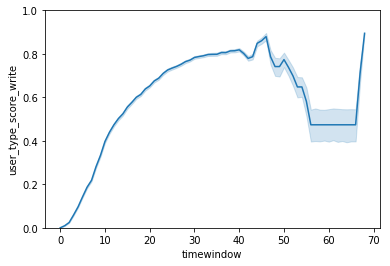

user_type_score_paste


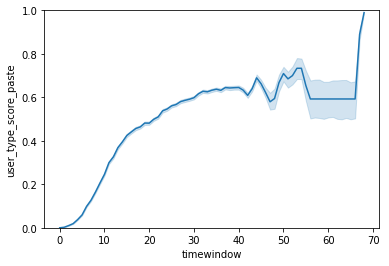

user_type_score_delete


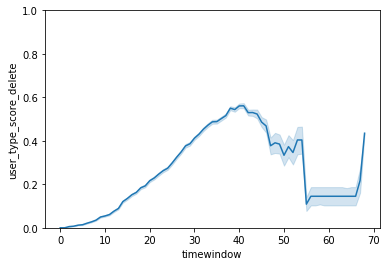

user_type_score_edit


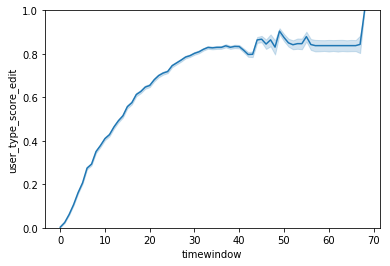

paragraph_average_length


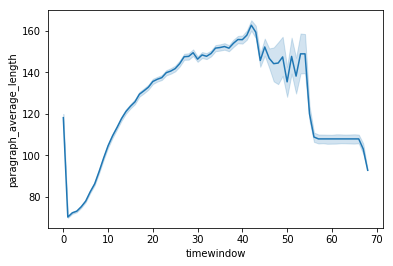

superparagraph_average_length


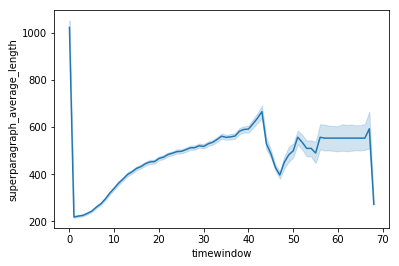

average_paragraphs_per_superparagraph


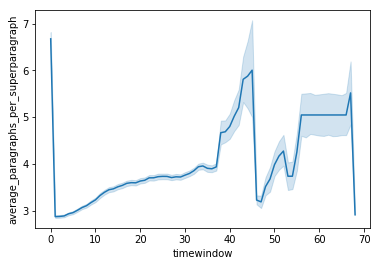

window_type_overall_score_write


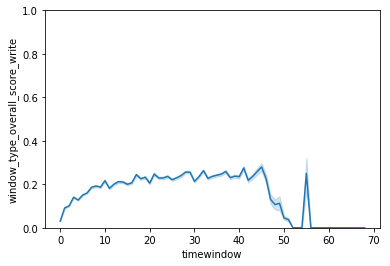

window_type_overall_score_paste


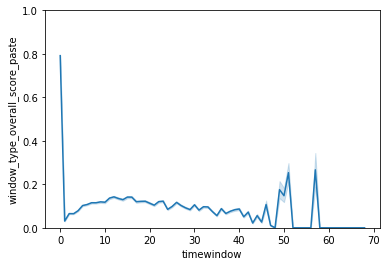

window_type_overall_score_delete


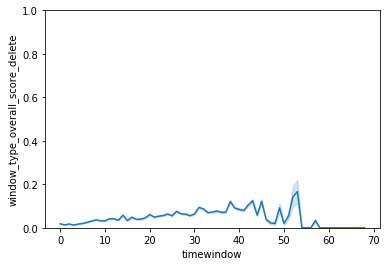

window_type_overall_score_edit


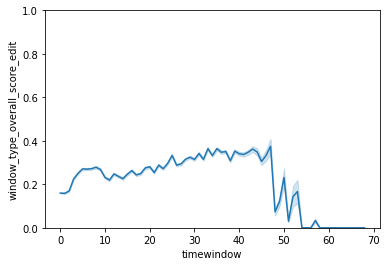

window_user_type_score_write


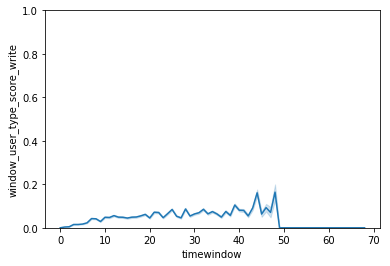

window_user_type_score_paste


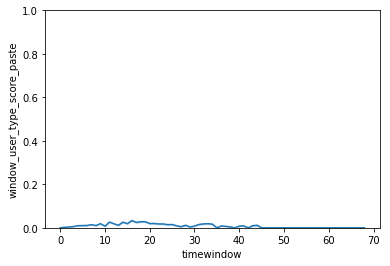

window_user_type_score_delete


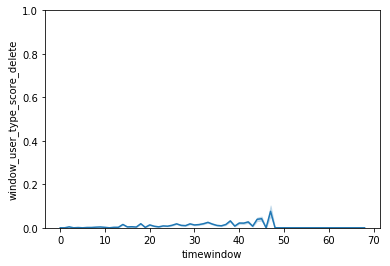

window_user_type_score_edit


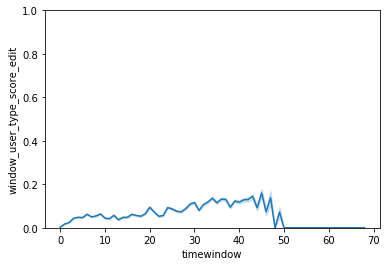

In [8]:
# plt.plot(np.transpose(clean_dfs[heuristic_name]))
for heuristic_name in heuristic_names[10:]:
    if heuristic_name not in ["break_score_short",
                              "added_chars",
                              "length",
                              "length_all",
                              "length_all_write",
                              "length_all_paste",
                              "length_all_delete",
                              "deleted_chars",
                              ""]:
        plt.figure()
        print(heuristic_name)
        sns.lineplot(x="timewindow", y=heuristic_name, data=clean_df)
        if "score" in heuristic_name:
            axes = plt.gca()
            axes.set_ylim([0,1])
            
        plt.show()

In [5]:
pad = pads["edusearch2014_report-149-25-2"]

Welcome to your Task Pad!  Use this pad to write your answer:


1) You and your partners need to reach consensus when you're finished and all click 'Submit'.
2) Avoid chatting in this space.  Use the chat for that!
3) Remember, we're looking for a report of the best supported claims.
4) Use the evidence you have (you'll need to decide how much to read) to create a summary for the minister.
5) Use boldface font to create headings.
6) You can insert URLs for references, or use in-line citations like this: (Templaar, 2014).


Good luck!


Red Yeast Rice


Definition:


Red yeast rice is a substance that's extracted from rice that's been  fermented with a type of yeast called Monascus purpureus. It's been used  in China and other Asian countries for centuries as a traditional  medicine. It's also used as a food colouring, additive, and  preservative.
Red yeast rice naturally contains several  ingredients that may help maintain healthy cholesterol levels, but this  is not proven. The ingred